# Evaluate model for US Stock Env

In [1]:
import torch as th
import vectorbt as vbt
import gymnasium as gym
from copy import deepcopy
from stock_env.common.common_utils import create_performance, plot_trade_log_v2
from stock_env.envs import *
from stock_env.common.evaluation import evaluate_agent, play_an_episode
from stock_env.algos.agent import MetaAgent
from stock_env.common.common_utils import open_config
import seaborn as sns
sns.set()
import plotly.graph_objects as go

In [2]:
env_id = 'SP500-v0'
state_dict_path = '../model/maml_sp500_20221217_141044.pth'
num_tasks = num_envs = 5
env_config = open_config('../configs/envs.yaml', env_id=env_id)

_env = MetaVectorEnv([lambda: gym.make(env_id) for _ in range(1)])
meta_agent = MetaAgent(_env)

# meta agent
meta_agent.load_state_dict(th.load(state_dict_path))
meta_agent.eval()

# random
random_agent = deepcopy(meta_agent)

## Evaluation on random period

In [3]:
num_envs = num_tasks = 5

eval_envs = MetaVectorEnv([lambda: gym.make(env_id) for _ in range(num_envs)])
eval_envs.train(False)

tasks = eval_envs.sample_task(num_tasks)
for env, task in zip(eval_envs.envs, tasks):
    env.reset_task(task)
    
mean, std = evaluate_agent(meta_agent, eval_envs, n_eval_episodes=100)
print(f"Mean reward: {mean:.2f} +/- {std: .2f}")

Mean reward: -232.62 +/-  241.05


# Evaluation on specific stocks

In [4]:
# INPUTS
# prepare tables
metrics = [
    'annual_return', 
    'cum_returns_final', 
    'sharpe_ratio', 
    'max_drawdown', 
    'annual_volatility', 
    'value_at_risk'
]
agents = {
    'MAML': meta_agent, 
    'Random': random_agent,
}
N_TASKS = 10

# Main process
single_eval_envs = MetaVectorEnv([lambda: gym.make(env_id) for _ in range(1)])
single_eval_envs.train(False)
tasks = single_eval_envs.sample_task(N_TASKS)

perf_df = pd.DataFrame(index=pd.MultiIndex.from_product([tasks, metrics]), columns=agents.keys())
for task in tasks:
    single_eval_envs.reset_task(task)
    
    for agent_key, agent in agents.items():
        # run model to get detailed information in the enviroment
        info = play_an_episode(agent, single_eval_envs)
        df = info['final_info'][0]['final_history']
        returns = df.set_index('time')['portfolio_value'].pct_change()
        perf = create_performance(returns, plot=False)
        
        for metric, value in perf.items():
            perf_df.loc[(task, metric), agent_key] = round(value * 100, 2)
    
    # buy and hold performance
    holding_returns = vbt.Portfolio.from_holding(df.close, init_cash=env_config.init_cash).value().pct_change()
    perf = create_performance(holding_returns, plot=False)
    for metric, value in perf.items():
        perf_df.loc[(task, metric), 'Buy-n-Hold'] = round(value * 100, 2)
perf_df

MAML  Random  Buy-n-Hold
CMCSA annual_return       -2.18  -28.41      -13.72
      cum_returns_final   -2.16  -28.22      -13.62
      sharpe_ratio        31.11     6.3      -40.25
      max_drawdown       -24.42  -39.34      -28.44
      annual_volatility   68.59   88.38       27.43
      value_at_risk         NaN     NaN         NaN
ENPH  annual_return       28.78  134.87      107.98
      cum_returns_final   27.11  124.75      100.27
      sharpe_ratio        70.97   178.5      137.18
      max_drawdown        -36.1  -20.61      -36.43
      annual_volatility    63.1   56.94       72.51
      value_at_risk         NaN     NaN         NaN
FOX   annual_return      -14.33   -8.84      -17.49
      cum_returns_final   -13.8   -8.51      -16.86
      sharpe_ratio        -45.8  -24.94      -46.68
      max_drawdown       -23.49  -21.79      -32.71
      annual_volatility   26.34   24.88       31.05
      value_at_risk         NaN     NaN         NaN
CL    annual_return      -33.37     6.9        9.21
      cum_returns_final  -14.47    6.84        9.14
      sharpe_ratio      -255.87   41.65       43.49
      max_drawdown       -18.48  -24.21      -22.57
      annual_volatility   15.55   62.14       31.89
      value_at_risk         NaN     NaN         NaN
VTR   annual_return      -20.14  -18.67      -14.46
      cum_returns_final  -19.35  -17.93      -13.87
      sharpe_ratio       -62.16  -59.99      -34.13
      max_drawdown        -31.1  -27.62      -41.80
      annual_volatility   29.36   28.03       31.50
      value_at_risk         NaN     NaN         NaN
IFF   annual_return      -37.71   -9.42      -13.30
      cum_returns_final  -16.66   -9.34      -13.21
      sharpe_ratio      -179.52  -16.58      -34.23
      max_drawdown       -22.71  -25.53      -29.68
      annual_volatility    24.9   30.92       29.32
      value_at_risk         NaN     NaN         NaN
PAYC  annual_return        7.34  -14.76        2.46
      cum_returns_final    6.59   -13.4        2.21
      sharpe_ratio        38.13  -15.55       31.12
      max_drawdown       -25.96  -39.24      -28.76
      annual_volatility   46.06    43.3       53.76
      value_at_risk         NaN     NaN         NaN
MU    annual_return        8.52   11.07      -17.14
      cum_returns_final    8.45   10.98      -17.01
      sharpe_ratio        40.75   47.26      -15.47
      max_drawdown       -26.98  -22.42      -45.00
      annual_volatility   36.06   36.32       47.99
      value_at_risk         NaN     NaN         NaN
PHM   annual_return       12.19   18.49       25.45
      cum_returns_final   12.09   18.33       25.23
      sharpe_ratio        51.02   66.22       79.70
      max_drawdown       -18.08  -20.68      -18.13
      annual_volatility    34.0   35.03       37.29
      value_at_risk         NaN     NaN         NaN
WFC   annual_return        11.1   10.01       13.82
      cum_returns_final   11.01    9.93       13.70
      sharpe_ratio        49.66   65.99       70.86
      max_drawdown       -23.47  -25.51      -23.11
      annual_volatility   30.78  115.59       21.70
      value_at_risk         NaN     NaN         NaN

In [6]:
perf_df['is_better'] = perf_df['MAML'] > perf_df['Buy-n-Hold']
perf_df.loc[(tasks, ('sharpe_ratio', 'max_drawdown')), :].sort_values('MAML', ascending=False)

,,MAML,Random,Buy-n-Hold,is_better
ENPH,sharpe_ratio,70.97,178.5,137.18,False
PHM,sharpe_ratio,51.02,66.22,79.70,False
WFC,sharpe_ratio,49.66,65.99,70.86,False
MU,sharpe_ratio,40.75,47.26,-15.47,True
PAYC,sharpe_ratio,38.13,-15.55,31.12,True
CMCSA,sharpe_ratio,31.11,6.3,-40.25,True
PHM,max_drawdown,-18.08,-20.68,-18.13,True
CL,max_drawdown,-18.48,-24.21,-22.57,True
IFF,max_drawdown,-22.71,-25.53,-29.68,True
WFC,max_drawdown,-23.47,-25.51,-23.11,False


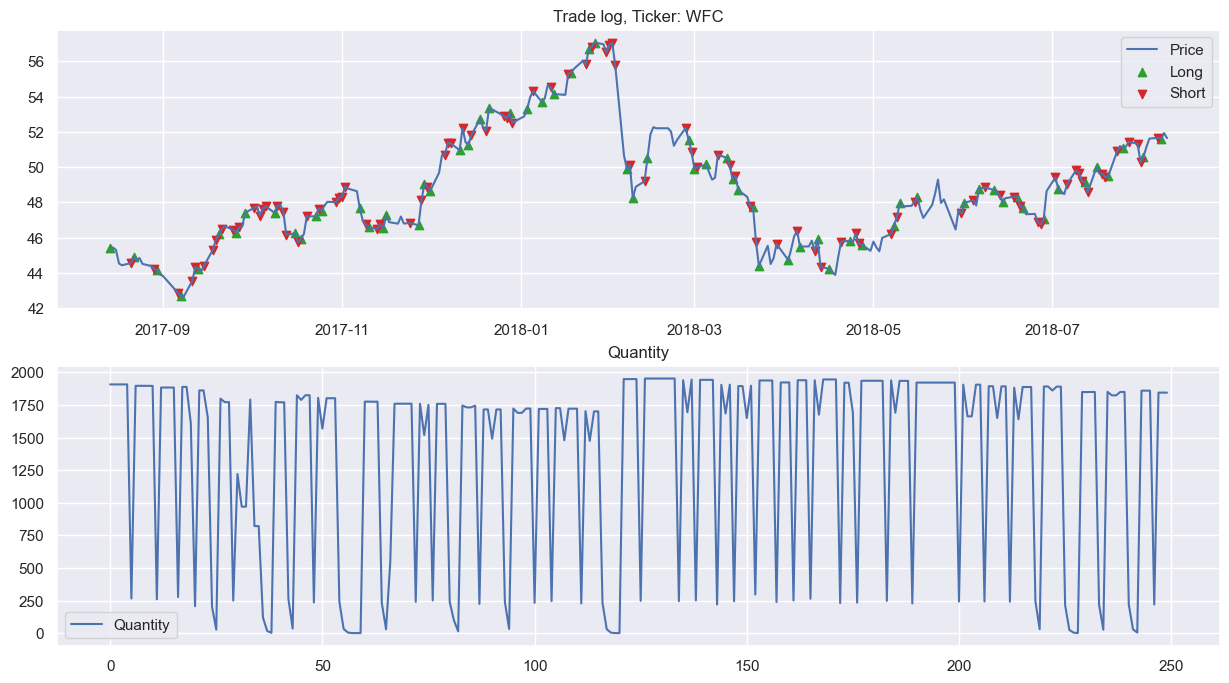

In [7]:
plot_trade_log_v2(df)

# Compare with buy-and-hold strategy and feature strategy

In [8]:
# portfolio value from hodling
df['pv_from_holding'] = vbt.Portfolio.from_holding(df.close, init_cash=env_config.init_cash).value()
df = df.set_index('time')
ticker = df['ticker_x'].unique()[0]

In [9]:
fig = go.Figure()
fig.update_layout(width=800, height=500)
fig.update_layout(title=f'Buy-n-Hold Comparision, Ticker: {ticker}', title_x=0.5)
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Portfolio Value ($)')

df['portfolio_value'].vbt.plot_against(
    other=df['pv_from_holding'],
    other_trace_kwargs=dict(
        line=dict(width=2, color='dimgray'),
        mode='lines',
        name='Buy-n-Hold'
    ),
    trace_kwargs=dict(
        mode='lines+markers',
        line=dict(width=3, color='lightslategray'),
        name='MAML',
    ),
    pos_trace_kwargs=dict(fillcolor='palegreen'),
    neg_trace_kwargs=dict(fillcolor='salmon'),
    fig=fig,
)
fig.show()